In [1]:
from qulacs import QuantumState,QuantumCircuit
from qulacs import ParametricQuantumCircuit
from qulacs.gate import RY,CZ,merge
from qulacs.state import inner_product
import numpy as np 
import random

import matplotlib.pyplot as plt

### Prepare training/test data

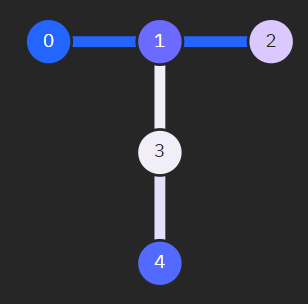

copied from Noro-san's code

In [2]:
class Dataset_generator():
    def __init__(self,n_qubits,epsilon,generator) -> None:
        self.n_qubits = n_qubits
        self.epsilon = epsilon 
        self.generator = generator
    
    def x_generator(self,c,select_bin_i):
        SS = np.copy(self.generator)
    
        #select = np.random.randint(0,2,n_qubits) # i番目の生成元を使う(1)か使わない(0)かを決める行列
        se = np.zeros(self.n_qubits)
        for j in range(self.n_qubits):
            se[j] = int(select_bin_i[j])
            
        for i in range(self.n_qubits):
            SS[i] = SS[i] * se[i]
        op = np.sum(SS, axis=0) # それぞれのビットにそれぞれのゲート(X, Z)が何回掛かるかを示す行列

        # \theta_{+-}を計算する
        theta = np.zeros(2*self.n_qubits)

        for i in range(self.n_qubits):
            theta[2*i] = c[2*i] + np.pi/2 * op[2*i]
            theta[2*i+1] = (-1)**op[2*i] * c[2*i+1] + np.pi/2 * op[2*i+1]

        for i in range(2*self.n_qubits): # 0～\piの値にする
            theta[i] = theta[i] % np.pi
        
        return theta

    def generate(self,n_data_train):
        l = [i for i in range(2**self.n_qubits)] # 0 = 2**n_qubits-1 のリスト
        select = random.sample(l, n_data_train)
        select_bin = [format(select[i], f'0{self.n_qubits}b') for i in range(n_data_train)]

        # c_{+-}を決める
        c_plus = np.pi/2 * np.random.rand(2*self.n_qubits) - np.pi/4 # - \pi/4 ～ \pi/4 のランダムな数
        c_minus = np.pi/2 * np.random.rand(2*self.n_qubits) - np.pi/4

        x_plus = []
        x_minus = []

        for i in range(n_data_train):
            xx = self.x_generator(c_plus, select_bin[i]).reshape((1,-1))
            e = np.random.normal(0, np.sqrt(epsilon), (1, 2*n_qubits))
            x_plus.append(xx + e)
            xx = self.x_generator(c_minus, select_bin[i]).reshape((1,-1))
            e = np.random.normal(0, np.sqrt(epsilon), (1, 2*n_qubits))
            x_minus.append(xx + e)
        x_plus = np.concatenate(x_plus)
        x_minus = np.concatenate(x_minus)
        x_train = np.concatenate([x_plus,x_minus])
        y_plus = np.ones(n_data_train)
        y_minus = -np.ones(n_data_train)
        y_train = np.concatenate([y_plus, y_minus]).reshape(1,-1)
        y_train = y_train.T

        return x_train, y_train
        

In [3]:
n_qubits = 5

# 用いるスタビライザー群の要素を決定する
# 生成元 XZIII, ZXZZI, IZXII, IZIXZ, IIIZX
S = np.zeros((n_qubits, 2*n_qubits))
S[0] = np.array([1,0, 0,1, 0,0, 0,0, 0,0]) # XZIII (X->1,0 Z->0,1 I->0,0としてならべる)
S[1] = np.array([0,1, 1,0, 0,1, 0,1, 0,0]) # ZXZZI
S[2] = np.array([0,0, 0,1, 1,0, 0,0, 0,0]) # IZXII
S[3] = np.array([0,0, 0,1, 0,0, 1,0, 0,1]) # IZIXZ
S[4] = np.array([0,0, 0,0, 0,0, 0,1, 1,0]) # IIIZX

n_data_train = 20
epsilon = 0.01 # エラーの分散

In [4]:
generator = Dataset_generator(n_qubits,epsilon,S)
x_train,y_train = generator.generate(n_data_train)

In [5]:
x_train

array([[ 2.9004084 ,  2.40124576,  1.09476785,  1.62668072,  1.07845455,
         2.25866059,  2.82885899,  0.92177575,  2.31294768,  2.9477733 ],
       [ 1.45608893,  0.74841283,  0.92172312,  0.11434839,  2.60000596,
         0.70908046,  1.46968552,  0.59542865,  0.93745983,  1.73247001],
       [ 1.30743451,  2.50455752,  2.60292562,  2.9843472 ,  2.80634357,
         2.3239754 ,  1.43683133,  0.56569968,  2.50843115,  1.44535701],
       [ 1.35947491,  0.89279624,  0.88397969,  0.13860563,  1.19764757,
         2.45194405,  2.93923341,  2.51856293,  0.93226887,  0.25687868],
       [ 3.1804058 ,  0.67263146,  2.54656369,  1.53670516,  1.05557851,
         0.53783643,  2.75240536,  1.10505076,  0.84658721,  0.16336217],
       [ 1.20538414,  0.81122262,  0.99534362,  0.05221048,  1.11290938,
         2.40613188,  2.85687788,  0.99464766,  2.59693784,  2.8933833 ],
       [ 3.13635748,  0.78352219,  2.48891583,  3.13668649,  1.28211385,
         0.60830651,  1.15555478,  2.16150854

### Create helper function to get fiducial states, kernel matrix

In [6]:
from cvxopt import matrix, solvers
def cvxopt_solver(Kernel,y,C):
    
    P = matrix(np.outer(y,y) * Kernel )
    q = matrix(- np.ones(y.shape[0]))
    n = Kernel.shape[0] 

    G = matrix(np.vstack(( - np.eye(n), np.eye(n)  ))) 
    h = matrix(np.vstack((np.zeros((n, 1)), np.full((n, 1),C) )))
    A = matrix(y, (1,n))
    b = matrix(np.zeros(1), (1, 1))

    solvers.options["maxiters"] = 10000
    solvers.options["show_progress"] = False

    sol = solvers.qp(P,q,G,h,A,b)
    return sol 

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
class CovariantKernel:

    def __init__(self,n_qubits,edges) -> None:
        self.n_qubits = n_qubits
        self.edges = edges

    def create_featured_gate(self,Lambda,x):
        circuit = ParametricQuantumCircuit(self.n_qubits)
        for i in range(self.n_qubits):
            circuit.add_parametric_RY_gate(i,-Lambda[i])
        for control, target  in self.edges:
            circuit.add_CZ_gate(control,target)

        for i in range(self.n_qubits):
            circuit.add_RZ_gate(i,x[2*i])
            circuit.add_RX_gate(i,x[2*i+1])

        return circuit


    def get_kernel_value(self,x1,x2,Lambda):

        state1 = QuantumState(self.n_qubits)
        state2 = QuantumState(self.n_qubits)
        state1.set_zero_state()
        state1.set_zero_state()

        circuit1 = self.create_featured_gate(Lambda,x1)
        circuit2 = self.create_featured_gate(Lambda,x2)

        circuit1.update_quantum_state(state1)
        circuit2.update_quantum_state(state2)

        return abs(inner_product(state1,state2))**2
    
    def construct_kernel_matrix(self,Lambda,x):

        kernel_matrix = np.identity(x.shape[0])
        for i in range(x.shape[0]):
            for j in range(i):
                if i != j:
                    kernel_matrix[i,j] = self.get_kernel_value(x[i],x[j],Lambda)
                    kernel_matrix[j,i] = kernel_matrix[i,j]
        
        return kernel_matrix

    def predict(self,y_train, x_train,x_test,alpha=None,Lambda=None):
        if alpha is None:
            alpha = self.alpha_history[-1]
        if Lambda is None:
            Lambda = self.lam_history[-1]
        
        y_pred = []
        lam_vector = np.full(self.n_qubits, Lambda)

        for j in range(len(x_test)):
            kernel_value = np.array([self.get_kernel_value(x_train[i],x_test[j],lam_vector) for i in range(len(x_train))]).reshape(-1,1)
            threshold = np.sign(np.sum(y_train*alpha*kernel_value))
            y_pred.append(threshold)
        return y_pred


                

    def fit(self,x_train,y_train,lam0=0.1,C=1,P=20,c=0.1,gamma=0.101,a=0.05,A=1,sigma=0.602):
        
        self.lam_history = []
        self.F_history = []
        self.K_history = []
        self.alpha_history = []
        self.acc_history = []

        np.random.seed(1111)
        lam = np.full(n_qubits, lam0)
        for i in range(P):

            c_i =  c / (i + 1)** gamma
            a_i = a / ( i + 1 + A)** sigma

            Delta = 2*np.random.randint(0, 2, 1) - 1 
            lam_plus = lam + c_i * Delta
            lam_minus = lam - c_i * Delta

            K = self.construct_kernel_matrix(lam, x_train)
            K_plus = self.construct_kernel_matrix(lam_plus, x_train)
            K_minus = self.construct_kernel_matrix(lam_minus, x_train)

            sol = cvxopt_solver(K,y_train,C)
            sol_plus = cvxopt_solver(K_plus,y_train,C)
            sol_minus = cvxopt_solver(K_minus,y_train,C)
            alpha_plus = np.array(sol_plus['x']).reshape(-1)
            alpha_minus = np.array(sol_minus['x']).reshape(-1)
            alpha = sol['x']

            F_plus = - sol_plus['primal objective']
            F_minus = - sol_minus['primal objective']
            F = - sol['primal objective']
            y_pred = self.predict(y_train,x_train,x_train,alpha,lam)
            acc_score = accuracy_score(y_train,y_pred)

            lam = lam - (F_plus - F_minus)* Delta* a_i / (2 *c_i)
            self.lam_history.append(lam[0])
            self.F_history.append(F)
            self.K_history.append(K)
            self.alpha_history.append(alpha)
            self.acc_history.append(acc_score)
            
        

        

In [9]:
edges= [[0,1],[1,2],[1,3],[3,4]]

In [10]:
kernel = CovariantKernel(n_qubits,edges)
kernel.fit(x_train,y_train)

In [11]:
kernel.lam_history

[0.1922798442270371,
 0.34260448330375215,
 0.5321121471520116,
 0.702284960302656,
 0.8262367563056539,
 0.9079320957997349,
 0.9623151056800111,
 0.9994912693305008,
 1.0255525925475195,
 1.0442984073286317,
 1.0581117925764407,
 1.0685096214721517,
 1.076482248787317,
 1.082693348441786,
 1.0875990901912704,
 1.0915203918084904,
 1.094687770075038,
 1.0972698956164957,
 1.0993922248465842,
 1.1011494414742906]

In [12]:
acc_scores = np.array(kernel.acc_history)

In [13]:
acc_scores

array([0.85 , 0.875, 0.925, 0.925, 0.925, 0.9  , 0.9  , 0.9  , 0.9  ,
       0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925,
       0.925, 0.925])

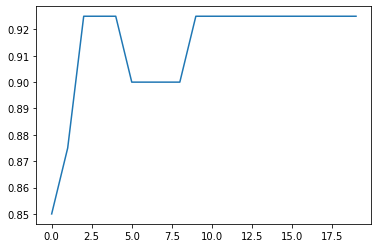

In [14]:
x = np.arange(0,20,1)
plt.plot(x,acc_scores)